# Imports

In [9]:
import numpy as np
import os
import sys
import pickle
import scipy
import scipy.stats as stats
import pandas as pd
import seaborn as sns
import matplotlib as plt
import statsmodels.api
import statsmodels as sm

## Helper Functions

In [10]:
%store -r analysis_hf
sys.path.insert(0, analysis_hf)

import nodeMapping as nm
import normalize as norm

# Set Directory Paths

In [11]:
# Only used to load the FTDGeneralData_20221114.mat file --> Saved as NetworkDataGeneral
%store -r baseDir

# Directory path to load formatted Pathology Data
%store -r path_dataDir

# Directory path to save Calcualted Analysis Data
%store -r path_CalData

# Directory path to save Figures
%store -r path_Fig

# Loading

## Loading the preconstructed atlas data

In [12]:
# loads the preconstructed Atlas data
NetworkDataGeneral = scipy.io.loadmat(os.path.join(baseDir, 'NetworkAnalysisGeneral', 'FTDGeneralData_20221114.mat'))

## Loading Pathology Data (TAU, TDP) - Dropped

In [13]:
# path_TAU_Drop
with open(os.path.join(path_dataDir, 'path_TAU_Drop.pkl'), 'rb') as f:
    path_TAU_Drop = pickle.load(f)
f.close()

# path_TDP_Drop
with open(os.path.join(path_dataDir, 'path_TDP_Drop.pkl'), 'rb') as f:
    path_TDP_Drop = pickle.load(f)
f.close()

## Loading Pathology Labels (TAU, TDP) - Dropped

In [14]:
# pathNames_TAU_Drop
with open(os.path.join(path_CalData, 'pathNames_TAU_Drop.pkl'), 'rb') as f:
    pathNames_TAU_Drop = pickle.load(f)
f.close()

# pathNames_TDP_Drop
with open(os.path.join(path_CalData, 'pathNames_TDP_Drop.pkl'), 'rb') as f:
    pathNames_TDP_Drop = pickle.load(f)
f.close()

## Loading pathCoM (TAU, TDP) - Dropped

In [15]:
# CoM_TAU_Drop
with open(os.path.join(path_dataDir, 'CoM_TAU_Drop.pkl'), 'rb') as f:
    CoM_TAU_Drop = pickle.load(f)
f.close()

# CoM_TDP_Drop
with open(os.path.join(path_dataDir, 'CoM_TDP_Drop.pkl'), 'rb') as f:
    CoM_TDP_Drop = pickle.load(f)
f.close()

# T-test between TAU vs TDP

## Checking if there is region differences between TAU and TDP due to Drop in Observations

In [16]:
# Number of regions of Pathology (N = 40)
N = path_TAU_Drop.shape[1]

## T-test. Since the sample numbers are different between TAU and TDP, we would perform Welch's t-test

In [17]:
TAU_gt_TDP_Ttest_stat_list = []
TAU_gt_TDP_Ttest_pval_list = []

TDP_gt_TAU_Ttest_stat_list = []
TDP_gt_TAU_Ttest_pval_list = []


for i in range(N):
    TAU_data = path_TAU_Drop[:, i]
    TDP_data = path_TDP_Drop[:, i]

    # ignore NaN Values in T-test
    TAU_gt_TDP_Ttest = stats.ttest_ind(a=TAU_data, b=TDP_data, equal_var=False, alternative='greater', nan_policy='omit')
    TDP_gt_TAU_Ttest = stats.ttest_ind(a=TAU_data, b=TDP_data, equal_var=False, alternative='less', nan_policy='omit')

    TAU_gt_TDP_Ttest_stat = TAU_gt_TDP_Ttest[0]
    TAU_gt_TDP_Ttest_pval = TAU_gt_TDP_Ttest[1]

    TAU_gt_TDP_Ttest_stat_list.append(TAU_gt_TDP_Ttest_stat)
    TAU_gt_TDP_Ttest_pval_list.append(TAU_gt_TDP_Ttest_pval)

    TDP_gt_TAU_Ttest_stat = TDP_gt_TAU_Ttest[0]
    TDP_gt_TAU_Ttest_pval = TDP_gt_TAU_Ttest[1]

    TDP_gt_TAU_Ttest_stat_list.append(TDP_gt_TAU_Ttest_stat)
    TDP_gt_TAU_Ttest_pval_list.append(TDP_gt_TAU_Ttest_pval)
    

## Multiple Comparison Correction / alpha = 0.05 / Method: Benjamini/Hochberg (non-negative)

### Corrected for TAU > TDP

In [18]:
TAU_gt_TDP_reject, TAU_gt_TDP_pvals_corrected, alphacSidak, alphacBonf = sm.stats.multitest.multipletests(TAU_gt_TDP_Ttest_pval_list, alpha=0.05,
                                                                                                           method='fdr_bh', is_sorted=False, 
                                                                                                           returnsorted=False)

### Corrected for TDP > TAU

In [19]:
TDP_gt_TAU_reject, TDP_gt_TDP_pvals_corrected, alphacSidak, alphacBonf = sm.stats.multitest.multipletests(TDP_gt_TAU_Ttest_pval_list, alpha=0.05,
                                                                                                          method='fdr_bh', is_sorted=False, 
                                                                                                          returnsorted=False)

## TAU > TDP

In [20]:
# Pandas DataFrame
TAU_gt_TDP_df = pd.DataFrame(np.concatenate((np.array(TAU_gt_TDP_pvals_corrected).reshape((-1, 1)), 
                                             np.array(TAU_gt_TDP_reject).reshape((-1, 1))), axis=1), 
                                             columns=['corrected pval', 'Result'], index=pathNames_TAU_Drop)

TAU_gt_TDP_df['Result'] = TAU_gt_TDP_df['Result'].astype('bool')

In [21]:
TAU_gt_TDP_df

,corrected pval,Result
ANG_L,3.899843e-09,True
ATC_L,7.103142e-04,True
HIP_L,5.156948e-06,True
IFC_L,3.516484e-05,True
M1_L,1.680535e-08,True
MFC_L,2.812864e-14,True
OFC_L,2.370096e-07,True
SMTC_L,1.605450e-09,True
SPC_L,1.659683e-07,True
V1_L,2.786328e-07,True


## TDP > TAU

In [22]:
# Pandas DataFrame
TDP_gt_TAU_df = pd.DataFrame(np.concatenate((np.array(TDP_gt_TDP_pvals_corrected).reshape((-1, 1)), 
                                             np.array(TDP_gt_TAU_reject).reshape((-1, 1))), axis=1), 
                                             columns=['corrected pval', 'Result'], index=pathNames_TDP_Drop)

TDP_gt_TAU_df['Result'] = TDP_gt_TAU_df['Result'].astype('bool')

In [23]:
TDP_gt_TAU_df

,corrected pval,Result
ANG_L,1.0,False
ATC_L,1.0,False
HIP_L,1.0,False
IFC_L,1.0,False
M1_L,1.0,False
MFC_L,1.0,False
OFC_L,1.0,False
SMTC_L,1.0,False
SPC_L,1.0,False
V1_L,1.0,False


In [24]:
# Log %AO of FTD TAU vs TDP
path_TAU_exp = path_TAU_Drop.copy()
path_TDP_exp = path_TDP_Drop.copy()

# Get min/max %AO TAU/TDP
minPath_TAU = np.nanmin(path_TAU_exp, axis=0)
maxPath_TAU = np.nanmax(path_TAU_exp - minPath_TAU + 0.0015, axis=0)

minPath_TDP = np.nanmin(path_TDP_exp, axis=0)
maxPath_TDP = np.nanmax(path_TDP_exp - minPath_TDP + 0.0015, axis=0)

#### Currently not doing Normalization ####
# Size of Nodes --> Marker
markerVecTAU = np.nanmean(path_TAU_exp, axis=0)
markerVecTAU = 7 * ((markerVecTAU - minPath_TAU) / maxPath_TAU)

markerVecTDP = np.nanmean(path_TDP_exp, axis=0)
markerVecTDP = 7 * ((markerVecTDP - minPath_TDP) / maxPath_TDP)

# Node color 
# --> If Null Hypothesis rejected: 4
# --> If Null Hypothesis cannotbe rejected: 1
colorVecTAU = np.where(TAU_gt_TDP_reject.astype('int') + 1 == 2, 4, TAU_gt_TDP_reject.astype('int') + 1)
colorVecTDP = np.where(TDP_gt_TAU_reject.astype('int') + 1 == 2, 4, TDP_gt_TAU_reject.astype('int') + 1)

In [30]:
NetworkDataGeneral

{'__header__': b'MATLAB 5.0 MAT-file, Platform: MACI64, Created on: Mon Nov 14 17:21:27 2022',
 '__version__': '1.0',
 '__globals__': [],
 'NetworkDataGeneral': array([[(array([[(MatlabOpaque([(b'', b'MCOS', b'table', array([[3707764736],
                                      [         2],
                                      [         1],
                                      [         1],
                                      [         1],
                                      [         1]], dtype=uint32))         ],
                              dtype=[('s0', 'O'), ('s1', 'O'), ('s2', 'O'), ('arr', 'O')]), array([[(array([[(array([[     1,  40965,  40963],
                                        [     1,  40963,  40966],
                                        [     1,  40966,  40968],
                                        ...,
                                        [327684, 324769, 203833],
                                        [326956, 324769, 327684],
                      

In [26]:
CoM_TAU_Drop

array([[-41.26326752, -65.73356628,  36.15997187],
       [-42.36386108,   1.03351961, -25.5229435 ],
       [-25.22740555, -16.62972403, -28.82517529],
       [-46.29314499,  19.91403294,   8.04273887],
       [-43.86865997,  -7.98697188,  41.49483967],
       [-38.51215363,  13.03796983,  37.25460958],
       [-10.90976524,  28.60049884, -18.12620926],
       [-56.05636501, -22.91237593,   0.32856068],
       [-27.17643642, -52.31694031,  56.57724476],
       [-16.96017838, -67.59367243,   3.686034  ],
       [ -9.09673548,  23.98545742,  25.98642635],
       [-32.29449158,  13.55492001,   2.34797442],
       [-47.79557673, -13.31423314, -32.1036822 ],
       [-31.42992859,  41.50729599,  18.90354519],
       [-39.610864  ,  38.23739878,  -7.61797142],
       [ -8.43030953, -41.1115551 ,  28.01900005],
       [ 45.20604324, -59.65849559,  34.36328952],
       [ 43.30150032,   5.22131538, -29.82507753],
       [ 23.19138718, -21.01649284, -25.15087318],
       [ 46.13744736,  22.72546

In [27]:
pathNames_TAU_Drop

array(['ANG_L', 'ATC_L', 'HIP_L', 'IFC_L', 'M1_L', 'MFC_L', 'OFC_L',
       'SMTC_L', 'SPC_L', 'V1_L', 'aCING_L', 'aINS_L', 'aITC_L',
       'dlPFC_L', 'iPFC_L', 'pCING_L', 'ANG_R', 'ATC_R', 'HIP_R', 'IFC_R',
       'M1_R', 'MFC_R', 'OFC_R', 'SMTC_R', 'SPC_R', 'V1_R', 'aCING_R',
       'aINS_R', 'aITC_R', 'dlPFC_R', 'iPFC_R', 'pCING_R'], dtype=object)

In [28]:
markerVecTAU

array([3.9545353 , 5.24699828, 3.82454049, 3.4047556 , 3.70727186,
       4.04751237, 3.13168592, 4.07241677, 5.01457066, 3.7967053 ,
       3.33299693, 3.79989456, 4.98606138, 3.07495256, 3.94781217,
       4.09169407, 3.4171191 , 3.47364053, 5.20995968, 4.00140468,
       3.41643232, 3.6321255 , 3.37386728, 3.68030247, 3.40148704,
       2.73644046, 3.32123506, 4.20173575, 4.47825106, 3.49709574,
       4.10472291, 2.96855001])

In [29]:
colorVecTAU

array([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4])

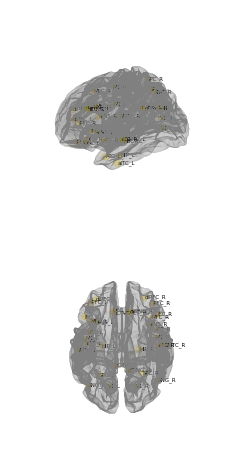

In [25]:
nm.nodeMapping(NetworkDataGeneral, CoM_TAU_Drop, pathNames_TAU_Drop, markerVecTAU, colorVecTAU, path_Fig, 
               'Node_3D_Mapping_TAU', nodeTransparency = 0.3, atlasTransparency = 0.01, showLabels = 1, surfDisp=None)